__Canny Edge Detector Python__

In [2]:
import numpy as np
import cv2
from matplotlib import pyplot as plt

Canny Edge Operator is composed of 5 steps

1. Noise Reduction
2. Gradient
3. Non-Max supression
4. Thresholding
5. Hysteresis for edge tracking

Load image 1 and image 2 which are MRI images of the sagittal plane of brain and convert to grayscale

(249, 202, 3)
(249, 202)


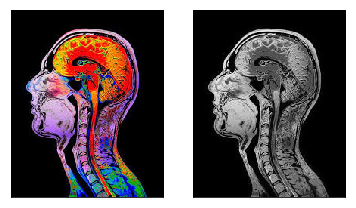

In [58]:
img = cv2.imread('image1.jpg')
print(img.shape)
RGB_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

grayImage=cv2.cvtColor(RGB_img, cv2.COLOR_RGB2GRAY)
print(grayImage.shape)

plt.subplot(1, 2, 1)
plt.xticks([]), plt.yticks([]) 
plt.imshow(RGB_img)

plt.subplot(1, 2, 2)
plt.xticks([]), plt.yticks([]) 
plt.imshow(grayImage,cmap = 'gray')


plt.show()


1. Noise Reduction


- Remove noise with Gaussian Blur/Kernel
- 3x3, 5x5, 7x7 odd kernel sizes are used, larger the kernel the more visible the blur effect

In [59]:
# kernel size is 2k+1 x 2k+1 want to have it as odd so... // 2
def gaussian_kernel(size,sigma):
    size = size //2
    x,y=np.mgrid[-size:size+1,-size:size+1] # create a mesh grid
    cons=(1/(2*np.pi*sigma**2))
    kernel=np.exp(-((x**2+y**2)/(2*sigma**2)))*cons
    return kernel

In [60]:
from scipy import signal
Smoothed_image=signal.convolve2d(grayImage,gaussian_kernel(5,1))

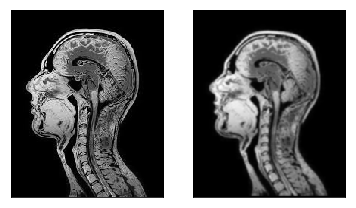

In [61]:
plt.subplot(1, 2, 1)
plt.xticks([]), plt.yticks([]) 
plt.imshow(grayImage,cmap = 'gray')

plt.subplot(1, 2, 2)
plt.xticks([]), plt.yticks([]) 
plt.imshow(Smoothed_image,cmap = 'gray')
plt.show()

2. Gradient Calculation.


- The gradient will help find the edges, since edges are typically known to be a change in pixel intensity in an image
- sobel filter is common gradient operator to use which will yield a magnitude and direction

In [62]:
# sobel filter without using actual function
def sobelfilter(smoothed_image):
    Gx=np.array([[-1,0,1],[-2,0,2],[-1,0,1]],np.float32)
    Gy=np.array([[1,2,1],[0,0,0],[-1,-2,-1]],np.float32)
    
    Ix=signal.convolve2d(smoothed_image,Gx)
    Iy=signal.convolve2d(smoothed_image,Gy)
    
    magnitude=np.sqrt(Ix**2+Iy**2)
    orgmag=magnitude
    magnitude=magnitude/magnitude.max() *255
    direction=np.arctan2(Iy,Ix)

    return magnitude,direction,orgmag;

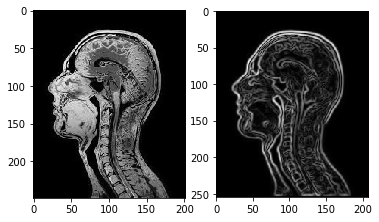

In [63]:
G,theta,Gorg=sobelfilter(Smoothed_image)

plt.subplot(1, 2, 1)
plt.imshow(grayImage,cmap = 'gray')

plt.subplot(1, 2, 2)
plt.imshow(G,cmap = 'gray')
plt.show()

In [64]:
print(G[150:155,100:105])
print(G.min(),G.max())

[[ 12.75423363  43.79257557 107.15423455 124.91936305  75.41786292]
 [ 10.36532707  35.13268195 109.52268814 128.75584793  82.71470967]
 [ 28.67124127  41.26682634 114.26932146 131.72975712  89.44310871]
 [ 73.12836862  80.79643851 116.68562236 120.36338285  85.51615465]
 [ 79.71523672  96.84777734 109.92045289  94.372275    72.78710654]]
0.0 255.0


3. Non-Maximum Supression


- The final image should have thin edges or lines, we should thin out the edges so that the lines are uniform and not varying from 0-255. ie, have edges all at one intensity level
- Go through all the points on the Gradient matrix of image and find pixels with maximum value in the edge directions
- Purpose of Algorithm: check if the pixels on the same direction are more or less intense than the pixel being processing in the viewing window. If the pixels on the same direction are more intense then they are kept and current pixel at (i,j) is set to 0. 

Non-max Supression steps:

1. create zeros matrix of same size as image
2. find the edge direction based on the angle (theta) matrix
3. check if the pixel in that direction has a higher intensity than the current one
4. return image that is non-max supressed

In [65]:
def non_maxsup(img, theta):
    M, N = img.shape
    Z = np.zeros((M,N), dtype=np.int32)
    angle = theta * 180 / np.pi
    angle[angle < 0] += 180

    
    for i in range(1,M-1):
        for j in range(1,N-1):
            try:
                q = 255
                r = 255
                # if the angle at each pixel is within a range set
                # the comparison pixels equal to the corresponding line
                # pixels. If angle not within then set that non-max image
                # pixel point to zero and keep pixel comparisons at max of
                # 255.
               #angle 0
                if (0 <= angle[i,j] < 22.5) or (157.5 <= angle[i,j] <= 180):
                    q = img[i, j+1]
                    r = img[i, j-1]
                #angle 45
                elif (22.5 <= angle[i,j] < 67.5):
                    q = img[i+1, j-1]
                    r = img[i-1, j+1]
                #angle 90
                elif (67.5 <= angle[i,j] < 112.5):
                    q = img[i+1, j]
                    r = img[i-1, j]
                #angle 135
                elif (112.5 <= angle[i,j] < 157.5):
                    q = img[i-1, j-1]
                    r = img[i+1, j+1]

                if (img[i,j] >= q) and (img[i,j] >= r):
                    Z[i,j] = img[i,j]
                else:
                    Z[i,j] = 0

            except IndexError as e:
                pass
    
    return Z

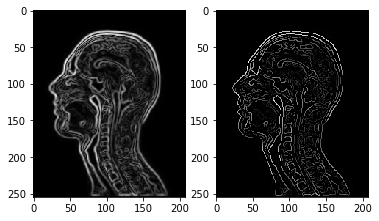

In [66]:
supressed_image=non_maxsup(G,theta)
plt.subplot(1, 2, 1)
plt.imshow(G,cmap = 'gray')

plt.subplot(1, 2, 2)
plt.imshow(supressed_image,cmap = 'gray')
plt.show()

4. Thresholding (double thresholding)


- pixels are strong, weak and non-relevant
- 1 threshold for identifying strong or high intensity pixels
- 1 threshold for identifying the non-relevent/low intensity pixels

In [67]:
def thresholding(img,lowthresh=.05,highthresh=.09):
    highThreshold=img.max()*highthresh
    lowThreshold=highThreshold*lowthresh
    
    M,N=img.shape
    res=np.zeros((M,N),dtype=np.int32)
    
    weak=np.int32(20)
    strong=np.int32(255)
    
    strong_i,strong_j=np.where(img>=highThreshold)
    zeros_i,zeros_j=np.where(img<lowThreshold)
    weak_i,weak_j=np.where((img<=highThreshold) & (img>=lowThreshold))
    res[strong_i,strong_j]=strong
    res[weak_i,weak_j]=weak
    
    return res,strong, weak;
    

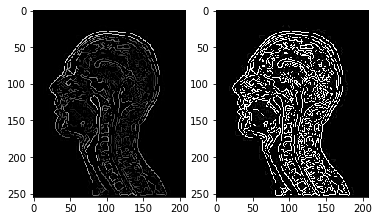

In [68]:
thresholdedImage,strongloc,weakloc=thresholding(supressed_image)
plt.subplot(1, 2, 1)
plt.imshow(supressed_image,cmap = 'gray')

plt.subplot(1, 2, 2)
plt.imshow(thresholdedImage,cmap = 'gray')

plt.show()

5. Hysteresis


- transform weak pixels (25) to strong only if there is at least one strong pixel around

In [69]:
def hysteresis(img,weak,strong):
    M,N=img.shape
    for i in range(1,M-1):
        for j in range(1,N-1):
            try:
                if img[i,j]==weak:
                    if ((img[i+1, j-1] == strong) or (img[i+1, j] == strong) or (img[i+1, j+1] == strong) or (img[i, j-1] == strong) or (img[i, j+1] == strong) or (img[i-1, j-1] == strong) or (img[i-1, j] == strong) or (img[i-1, j+1] == strong)):
                        img[i, j] = strong
                    else:
                        img[i, j] = 0
            except IndexError as e:
                pass
    return img

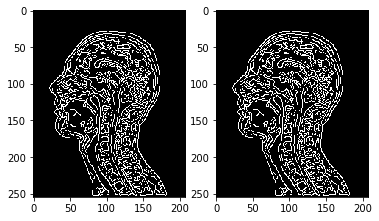

In [70]:
hysteresis_image=hysteresis(thresholdedImage,weakloc,strongloc)
plt.subplot(1, 2, 1)
plt.imshow(thresholdedImage,cmap = 'gray')

plt.subplot(1, 2, 2)
plt.imshow(hysteresis_image,cmap = 'gray')

plt.show()

In [35]:
np.array_equal(thresholdedImage,hysteresis_image)

True